In [1]:
# ==========================================
# Importação de Bibliotecas
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset e Pré-processamento
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Métricas
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Configuração de estilo visual
sns.set(style="whitegrid")
print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [2]:
# ==========================================
# Carga de Dados e Simulação de Duplicados
# ==========================================

# 1. Carregar dataset oficial (Breast Cancer Wisconsin)
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = Maligno, 1 = Benigno (na convenção sklearn)

# Para facilitar a interpretação médica, vamos inverter para: 1 = Maligno (Positivo), 0 = Benigno
df['target'] = df['target'].apply(lambda x: 0 if x == 1 else 1)

print(f"Dimensão original do dataset: {df.shape}")

# 2. SIMULAÇÃO DE ERRO: Injetar duplicatas artificialmente
# Vamos duplicar as primeiras 50 linhas para simular um erro de extração de dados
duplicatas = df.iloc[:50]
df_sujo = pd.concat([df, duplicatas], ignore_index=True)

print(f"Dimensão com duplicatas (Dataset Sujo): {df_sujo.shape}")
print(f"Número de registos duplicados: {df_sujo.duplicated().sum()}")

Dimensão original do dataset: (569, 31)
Dimensão com duplicatas (Dataset Sujo): (619, 31)
Número de registos duplicados: 50


In [3]:
# ==========================================
# Limpeza de Dados (Remoção de Redundância)
# ==========================================

# Como discutido na aula: Duplicatas no treino/teste criam um viés otimista irrealista.
# Solução: Deduplicação

df_limpo = df_sujo.drop_duplicates()

print(f"Dimensão após limpeza: {df_limpo.shape}")
print(f"Verificação de duplicatas restantes: {df_limpo.duplicated().sum()}")

# Separação de X (Atributos) e y (Target)
X = df_limpo.drop('target', axis=1)
y = df_limpo['target']

Dimensão após limpeza: (569, 31)
Verificação de duplicatas restantes: 0


In [4]:
# ==========================================
# Divisão Treino/Teste e Normalização
# ==========================================

# 1. Divisão Hold-out (70% Treino, 30% Teste)
# 'stratify=y' garante que mantemos a proporção de doentes/saudáveis em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Normalização (StandardScaler)
# IMPORTANTE: O KNN e a Regressão Logística são sensíveis à escala dos dados.
# O Naive Bayes (Gaussiano) lida bem sem, mas mal não faz neste contexto comparativo.
scaler = StandardScaler()

# Ajustamos (fit) apenas ao TREINO para evitar vazamento de dados (data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados divididos e normalizados.")
print(f"Treino: {X_train_scaled.shape[0]} amostras")
print(f"Teste: {X_test_scaled.shape[0]} amostras")

Dados divididos e normalizados.
Treino: 398 amostras
Teste: 171 amostras


In [6]:
# ==========================================
# Treino dos Modelos
# ==========================================

# Dicionário para armazenar os nossos classificadores
modelos = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Regressão Logística": LogisticRegression(random_state=42),
    "Naive Bayes": GaussianNB()
}

resultados = {}

print("A treinar modelos...")
for nome, modelo in modelos.items():
    # Treinar
    modelo.fit(X_train_scaled, y_train)
    # Prever
    y_pred = modelo.predict(X_test_scaled)
    # Guardar previsões para avaliação
    resultados[nome] = y_pred
    print(f"-> {nome} treinado.")

A treinar modelos...
-> KNN (k=5) treinado.
-> Regressão Logística treinado.
-> Naive Bayes treinado.


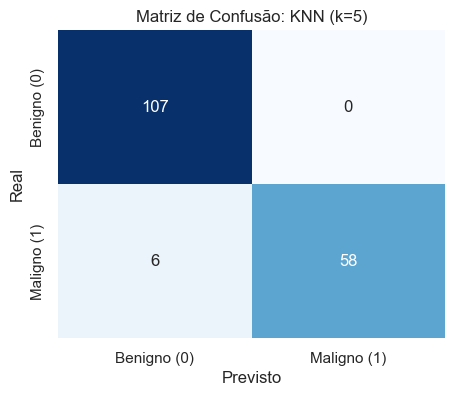

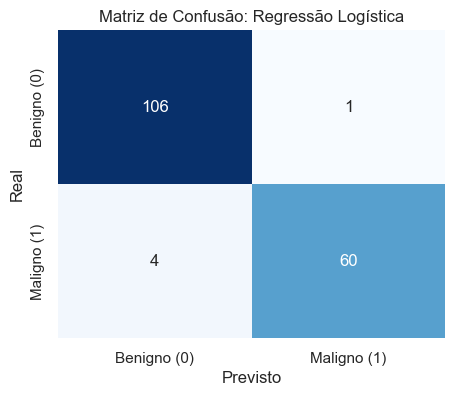

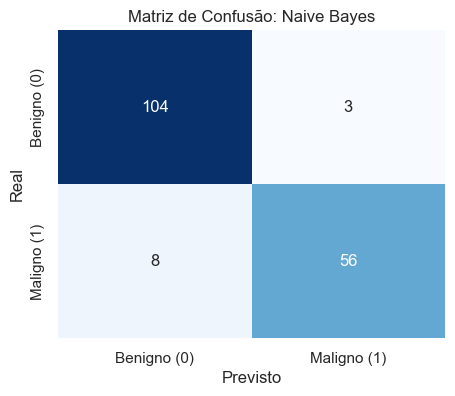

In [7]:
# ==========================================
# Avaliação e Comparação Visual
# ==========================================

# Função auxiliar para desenhar Matriz de Confusão
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benigno (0)', 'Maligno (1)'],
                yticklabels=['Benigno (0)', 'Maligno (1)'])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão: {title}')
    plt.show()

# Lista para guardar métricas finais
comparativo = []

for nome, y_pred in resultados.items():
    # 1. Calcular Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Adicionar à lista comparativa
    comparativo.append({
        "Modelo": nome,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    # 2. Mostrar Matriz de Confusão
    plot_conf_matrix(y_test, y_pred, nome)

# Criar DataFrame final de comparação
df_comparativo = pd.DataFrame(comparativo).set_index("Modelo")

In [8]:
# ==========================================
# CÉLULA 7: Tabela Final de Resultados
# ==========================================

print("--- COMPARAÇÃO DE PERFORMANCE ---")
# Formatar para mostrar percentagens
display(df_comparativo.style.format("{:.2%}").background_gradient(cmap='Greens'))

# Análise rápida (print):
print("\nObservações para a Aula:")
print("1. Accuracy: Qual modelo acertou mais no geral?")
print("2. Recall: Qual modelo foi melhor a detetar o cancro (Classe 1)? (Evitou Falsos Negativos)")
print("3. Naive Bayes: Foi competitivo mesmo assumindo independência dos atributos?")

--- COMPARAÇÃO DE PERFORMANCE ---


,Accuracy,Precision,Recall,F1-Score
Modelo,,,,
KNN (k=5),96.49%,100.00%,90.62%,95.08%
Regressão Logística,97.08%,98.36%,93.75%,96.00%
Naive Bayes,93.57%,94.92%,87.50%,91.06%



Observações para a Aula:
1. Accuracy: Qual modelo acertou mais no geral?
2. Recall: Qual modelo foi melhor a detetar o cancro (Classe 1)? (Evitou Falsos Negativos)
3. Naive Bayes: Foi competitivo mesmo assumindo independência dos atributos?
